In [1]:
import numpy as np
import scipy.fftpack
from scipy.special import logsumexp
from glob import glob
import matplotlib.pyplot as plt
#plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})

The following cell contains only code for MFCC feature extraction. At high level, it is enough to know that function **raw8khz2mfcc(dir_name)** loads all *.raw files from directory dir_name and returns a dictionary where keys are file names and values are numpy arrays with corresponding MFCC features.

In [2]:
# Field with feature extraction function

def mel_inv(x):
    return (np.exp(x/1127.)-1.)*700.

def mel(x):
    return 1127.*np.log(1. + x/700.)

def mel_filter_bank(nfft, nbands, fs, fstart=0, fend=None):
    """Returns mel filterbank as an array (nfft/2+1 x nbands)
    nfft   - number of samples for FFT computation
    nbands - number of filter bank bands
    fs     - sampling frequency (Hz)
    fstart - frequency (Hz) where the first filter strats
    fend   - frequency (Hz) where the last  filter ends (default fs/2)
    """
    if not fend:
      fend = 0.5 * fs

    cbin = np.round(mel_inv(np.linspace(mel(fstart), mel(fend), nbands + 2)) / fs * nfft).astype(int)
    mfb = np.zeros((nfft // 2 + 1, nbands))
    for ii in range(nbands):
        mfb[cbin[ii]:  cbin[ii+1]+1, ii] = np.linspace(0., 1., cbin[ii+1] - cbin[ii]   + 1)
        mfb[cbin[ii+1]:cbin[ii+2]+1, ii] = np.linspace(1., 0., cbin[ii+2] - cbin[ii+1] + 1)
    return mfb

def framing(a, window, shift=1):
    shape = ((a.shape[0] - window) // shift + 1, window) + a.shape[1:]
    strides = (a.strides[0]*shift,a.strides[0]) + a.strides[1:]
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)

def spectrogram(x, window, noverlap=None, nfft=None):
    if np.isscalar(window): window = np.hamming(window)
    if noverlap is None:    noverlap = window.size // 2
    if nfft     is None:    nfft     = window.size
    x = framing(x, window.size, window.size-noverlap)
    x = scipy.fftpack.fft(x*window, nfft)
    return x[:,:x.shape[1]//2+1]

def mfcc(s, window, noverlap, nfft, fs, nbanks, nceps):
    '''
    Mel Frequency Cepstral Coefficients extraction:
       CPS = MFCC(s, FFTL, Fs, WINDOW, NOVERLAP, NBANKS, NCEPS) returns
       NCEPS-by-M matrix of MFCC coeficients extracted form signal s, where
       M is the number of extracted frames, which can be computed as
       floor((length(S)-NOVERLAP)/(WINDOW-NOVERLAP)). Remaining parameters
       have the following meaning:
    
       NFFT          - number of frequency points used to calculate the discrete
                       Fourier transforms
       Fs            - sampling frequency [Hz]
       WINDOW        - window lentgth for frame (in samples)
       NOVERLAP      - overlapping between frames (in samples)
       NBANKS        - numer of mel filter bank bands
       NCEPS         - number of cepstral coefficients - the output dimensionality    
    '''

    # Add low level noise (40dB SNR) to avoid log of zeros
    snrdb = 40
    noise = np.random.rand(s.shape[0])
    s = s + noise.dot(np.linalg.norm(s, 2)) / np.linalg.norm(noise, 2) / (10 ** (snrdb / 20))

    mfb = mel_filter_bank(nfft, nbanks, fs, 32)
    dct_mx = scipy.fftpack.idct(np.eye(nceps, nbanks), norm='ortho') # the same DCT as in matlab

    S = spectrogram(s, window, noverlap, nfft)
    mfcc =  dct_mx.dot(np.log(mfb.T.dot(np.abs(S.T)))).T
    return mfcc


def raw8khz2mfcc(dir_name):
    """
    Loads all *.raw files from directory dir_name (speech signals sampled at 8kHz; 16 bits),
    converts them into MFCC features (13 coefficients) and stores them into a dictionary.
    Keys are the file names and values and 2D numpy arrays of MFCC features.
    """
    features = {}
    for f in glob(dir_name + '/*.raw'):
        print('Processing file: ', f)
        features[f] = mfcc(np.fromfile(f, np.int16, -1, ''), 200, 120, 256, 8000, 23, 13)
    return features

The following cell contains functions for HMM evaluation and training. Function **forward_backward** implements the forward_backward algorithm:

$$A(t,s) = p(\mathbf{x}_t|s)\sum_{s'}A(t-1,s')p(s|s')$$

$$B(t,s) = \sum_{s'}B(t+1,s')p(\mathbf{x}_{t+1}|s')p(s'|s),$$

where that all the quantities $A(t,s)$, $B(t,s)$, $p(\mathbf{x}_t|s)$ and $p(s|s')$ are kept in the log domain for numerical stability. The function also evaluates HMM as:

$$p(\mathbf{X}) = \sum_{s \in F} A(T,s)$$,

where the sum is over the set of possible final states (which is only the last stated in our example). Finally, the function also evaluates the state responsibilities necessary for updating parameters:


$$\gamma_{st} = p(s_t=s|\mathbf{X}) = \frac{A(t,s)B(t,s)}{p(\mathbf{X})}.$$

Function **logpdf_gauss** is an auxiliary function for evaluating log of multivariate Gaussian probability density function. Function **train_hmm** performs a single iteration of EM-algorithm for HMM training using a list of training examples (input sequences). It uses function **forward_backward** to calculate the responsibilities $\gamma_s(t)$ for each training sequence and updates the parameters of HMM state distributions $p(\mathbf{x}|s) = \mathcal{N}(\mathbf{x};\boldsymbol{\mu}_s, \boldsymbol{\Sigma}_s)$ as:

$$\boldsymbol{\mu}_s = \frac{\sum_t \gamma_{st}\mathbf{x}_t}{\sum_t \gamma_{st}}$$

$$\boldsymbol{\Sigma}_s = \frac{\sum_t \gamma_{st}(\mathbf{x}_t-\boldsymbol{\mu}_s)(\mathbf{x}_t-\boldsymbol{\mu}_s)^T}{\sum_t \gamma_{st}}.$$

Note that the sum of these update formulas are meant over all frames of all training examples. Function **logpdf_hmm** evaluates HMM (i.e. calculates log p(\mathbf{X})) for several input sequences.

In [3]:
def forward_backward(lls, tr, ip=[1.0], fs=[-1], evaluate_only=False):
    """
    Inputs:
        lls - matrix of pre-computed per-frame log HMM state output probabilities log p(x_t|s)
        tr  - matrix of transition probability p(s|s')
        ip  - vector of initial state probabilities p(s) (i.e. probability of starting in the state)
        fs  - is vector listing indices of possible final states
        if evaluate_only=True then only forward pass is used to evaluate the HMM model. Otherwise,
        backward pass is also used to evaluate responsibilities gamma
    Outputs:
        tll   - log p(X) evaluated for the input sequence X (represented by marix lls)
        gamma - matrix of per-frame state occupation posteriors
    """
    lnA = np.full_like(lls, -np.inf) # log forward probabilities
    lnB = np.full_like(lls, -np.inf) # log backward probabilities
    lnB[-1][fs] = 0.0
    with np.errstate(divide='ignore'):
        lnA[0][:len(ip)] = lls[0][:len(ip)] + np.log(ip)
        ltr = np.log(tr)

    # Forward pass
    for ii in  range(1,len(lls)):
        lnA[ii] =  lls[ii] + logsumexp(lnA[ii-1] + ltr.T, axis=1)

    tll = logsumexp(lnA[-1][fs])
        
    if evaluate_only:
        return tll

    # Backward pass
    for ii in reversed(range(len(lls)-1)):
        lnB[ii] = logsumexp(ltr + lls[ii+1] + lnB[ii+1], axis=1)
    
    gamma = np.exp(lnA + lnB - tll)
    return  tll, gamma

def logpdf_gauss(x, mu, cov):
    '''
    This function returns a vector of log Gaussian probability densities evaluated for feature vectors stored
    in rows of array 'x'. Vector ‘mu’ and matrix ‘cov’ are the parameters of the Gaussian distribution.
    '''
    assert(mu.ndim == 1 and len(mu) == len(cov) and (cov.ndim == 1 or cov.shape[0] == cov.shape[1]))
    x = np.atleast_2d(x) - mu
    return -0.5*(len(mu)*np.log(2 * np.pi) + np.linalg.slogdet(cov)[1] + np.sum(x.dot(np.linalg.inv(cov)) * x, axis=1))

def train_hmm(X, tr, ip, fs, mus, covs):
    '''
    This function performs a single iteration of EM-algorithm for HMM training and returns updated
    HMM parameter. It considers HMM model where the state distributions are modeled by (multivariate)
    Gaussian distributions. For simplicity, only updates for mean vectors and covariance matrices of
    the state distributions are provided. New transition probabilities are not calculated.
    
    Inputs:
        X    - list of numpy arrays, where each array corresponds to one training sequence
        tr   - matrix of transition probability p(s|s')
        ip   - vector of initial state probabilities p(s) (i.e. probability of starting in the state)
        fs   - is vector listing indices of possible final states
        mus  - list of mean vectors, each corresponding to one HMM state distribution
        covs - list of covariance matrices, each corresponding to one HMM state distribution
Outputs:
        tll   - total (forward) log-likelihood for all training data (i.e. the objective to optimize)
        gamma - matrix of per-frame state occupation posteriors
    '''    
    mus_acc = covs_acc = tr_acc = n_acc = tll_acc = 0.0
    for x in X: # For each training sequence ... 
        # evaluate state output probability p(x_t|s) for each frame t and each HMM state s
        lls = np.vstack([logpdf_gauss(x, m, c) for m, c in zip(mus, covs)]).T

        # and run the forward-backward algorithm to calculate responsibilities gamma
        tll, gamma = forward_backward(lls, tr, ip, fs)
        
        # Accumulate statistics for parameter updates
        n_acc    += gamma.sum(axis=0)
        mus_acc  += gamma.T @ x 
        covs_acc += (gamma.T[:,np.newaxis,:] * x.T[np.newaxis,:,:]) @ x
        tll_acc  += tll

    # Calculate the new model parameters
    mus  = mus_acc  / n_acc[:,np.newaxis]
    covs = covs_acc / n_acc[:,np.newaxis,np.newaxis] - mus[:,:,np.newaxis] * mus[:,np.newaxis,:]    
    return mus, covs, tll_acc

def logpdf_hmm(X, tr, ip, fs, mus, covs):
    '''
    This function evaluates HMM for several input sequences and returns vector of corresponding log 
    probability densities (i.e. one log p(x) for each input sequence x). It considers HMM model where
    the state distributions are modeled by (multivariate) Gaussian distributions.

    Inputs:
        X     - list of numpy arrays, where each array corresponds to one input sequence
        tr    - matrix of transition probability p(s|s')
        ip    - vector of initial state probabilities p(s) (i.e. probability of starting in the state)
        fs    - is vector listing indices of possible final states
        mus   - list of mean vectors, each corresponding to one HMM state distribution
        covs  - list of covariance matrices, each corresponding to one HMM state distribution
    Outputs:
        logPx - vecotr of log p(x) evaluated for each input sequence x
    '''    

    logPx=[]
    for x in X: # For each input sequence ...
        # evaluate state output probability p(x_t|s) for each frame t and each HMM state s
        lls = np.vstack([logpdf_gauss(x, m, c) for m, c in zip(mus, covs)]).T
        
        # and run the forward algorithm to evaluated the HMM model
        logPx.append(forward_backward(lls, tr, ip, fs, evaluate_only=True))
    return np.array(logPx)

Now, we load 59 training examples corresponding to speech recordings of the word "ANO". Each recodings is converted into a sequence of MFCC features. All the input sequences are stored in variable **train_ano** as a list of numpy arrays. Similarly, 60 training examples of word "NE" are stored in **train_ano**. Variables **test_ano** and **test_ne** are used to store lists of test examples (20 examples each).

In [4]:
train_ano = list(raw8khz2mfcc("ANO_NE/train_ano").values())
train_ne  = list(raw8khz2mfcc("ANO_NE/train_ne").values())
test_ano  = list(raw8khz2mfcc("ANO_NE/test_ano").values())
test_ne   = list(raw8khz2mfcc("ANO_NE/test_ne").values())

Processing file:  ANO_NE/train_ano\cut_A10100A0.raw
Processing file:  ANO_NE/train_ano\cut_A10101A0.raw
Processing file:  ANO_NE/train_ano\cut_A10102A0.raw
Processing file:  ANO_NE/train_ano\cut_A10103A0.raw
Processing file:  ANO_NE/train_ano\cut_A10104A0.raw
Processing file:  ANO_NE/train_ano\cut_A10105A0.raw
Processing file:  ANO_NE/train_ano\cut_A10106A0.raw
Processing file:  ANO_NE/train_ano\cut_A10107A0.raw
Processing file:  ANO_NE/train_ano\cut_A10108A0.raw
Processing file:  ANO_NE/train_ano\cut_A10109A0.raw
Processing file:  ANO_NE/train_ano\cut_A10110A0.raw
Processing file:  ANO_NE/train_ano\cut_A10111A0.raw
Processing file:  ANO_NE/train_ano\cut_A10112A0.raw
Processing file:  ANO_NE/train_ano\cut_A10113A0.raw
Processing file:  ANO_NE/train_ano\cut_A10114A0.raw
Processing file:  ANO_NE/train_ano\cut_A10115A0.raw
Processing file:  ANO_NE/train_ano\cut_A10116A0.raw
Processing file:  ANO_NE/train_ano\cut_A10117A0.raw
Processing file:  ANO_NE/train_ano\cut_A10118A0.raw
Processing f

We will have two HMMs, one for "ANO" and one for "NE". We initialize both to have 5 states and some dummy parameters for all the state distributions.

In [5]:
# Trasition probability matrix that will be used for both "ANO" and "NE" models 
tr = [[0.9, 0.1, 0.0, 0.0, 0.0],
      [0.0, 0.9, 0.1, 0.0, 0.0],
      [0.0, 0.0, 0.9, 0.1, 0.0],
      [0.0, 0.0, 0.0, 0.9, 0.1],
      [0.0, 0.0, 0.0, 0.0, 1.0]]

'''
tr = [[0.9, 0.1, 0.0, 0.0, 0.0, 0.0, 0.0],
      [0.0, 0.9, 0.1, 0.0, 0.0, 0.0, 0.0],
      [0.0, 0.0, 0.9, 0.1, 0.0, 0.0, 0.0],
      [0.0, 0.0, 0.0, 0.9, 0.1, 0.0, 0.0],
      [0.0, 0.0, 0.0, 0.0, 0.9, 0.1, 0.0],
      [0.0, 0.0, 0.0, 0.0, 0.0, 0.9, 0.1],
      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]]
'''

# The following vector says that we have to enter the HMM models in the first state (with probability 1.0) 
ip = [1.0] + [0.0]*(len(tr)-1)

# Only the last HMM state can be the final state
fs = [len(tr)-1]

# Initialize means and covariances of all HMM states (of both model) to some reasonable same values
allframes = np.vstack(train_ano+train_ne)
mus_ano  = mus_ne  = [np.mean(allframes, axis=0)]*len(ip)
covs_ano = covs_ne = [np.cov(allframes.T, bias=True)]*len(ip)

tlls=[]

We run several iterations of the EM-algorithm for each model to update their parameters. We also track and plot how the log likelihood of the training data improves over the iterations.

-52475.78419216969 -44914.92758138145
-47222.508008981386 -40156.0592462332
-44476.95317266858 -37198.808633842884
-44000.98520106712 -36609.48165797404
-43759.85169895124 -36532.32890390763
-43647.427371234786 -36495.58176163798
-43605.5480242117 -36444.290821887655
-43578.96907601337 -36412.79428759899
-43563.824187157414 -36393.23746692872
-43556.27246607008 -36377.88711586907
-43552.76617351075 -36371.49659201391
-43550.443926920394 -36368.20240773794
-43548.44357963269 -36365.784770972474
-43546.261016037264 -36363.04126306898
-43545.18875329202 -36359.22510402635
-43544.886470479534 -36352.347730005895
-43544.77547736816 -36341.34525021914
-43544.733286227915 -36334.81227135264
-43544.71680528465 -36329.56114101598
-43544.710147918624 -36324.903255770296


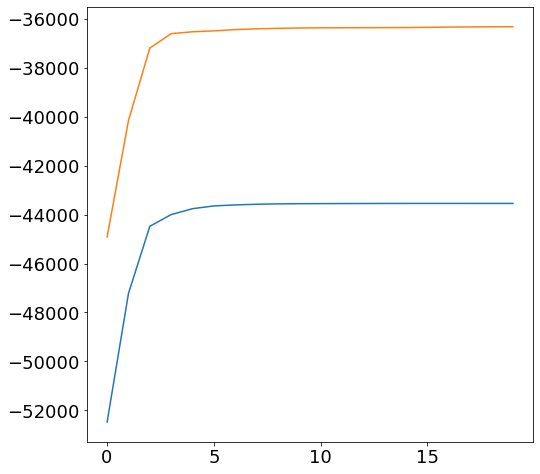

In [6]:
for i in range(20):
    mus_ano, covs_ano, tll_ano = train_hmm(train_ano, tr, ip, fs, mus_ano, covs_ano)
    mus_ne,  covs_ne,  tll_ne  = train_hmm(train_ne,  tr, ip, fs, mus_ne,  covs_ne)
    tlls.append((tll_ano,tll_ne))
    print(tll_ano, tll_ne)
plt.rcParams.update({'figure.figsize': (8.0, 8.0), 'font.size': 18})
plt.plot(tlls);

We take each test example and evaluate it using both trained HMM models. For each test example  $\mathbf{X}$, we evaluated log-likelihood ratio $ \log \frac{p(\mathbf{X}|ANO)}{p(\mathbf{X}|NE)}$, which we expect to be positive for the examples of the word "ANO" and negative for the examples of the word "NE". We plot histogram of the log-likelihood ratio scores and observe that this is usually the case.

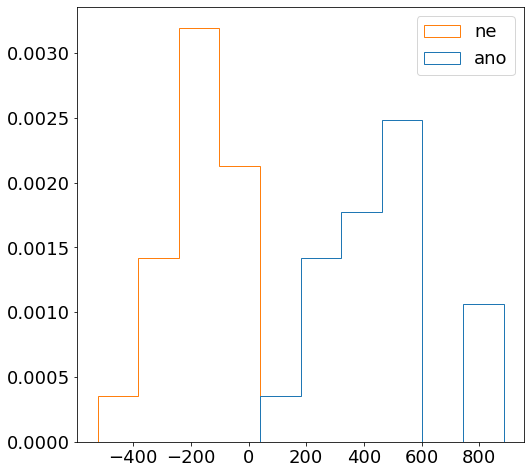

In [7]:
#Evaluate the log-likelihood ratios for all the test examples of the word ANO
ano_scores=(logpdf_hmm(test_ano, tr, ip, fs, mus_ano, covs_ano)
           -logpdf_hmm(test_ano, tr, ip, fs, mus_ne,  covs_ne))

#... and likewise for the word NE
ne_scores =(logpdf_hmm(test_ne,  tr, ip, fs, mus_ano, covs_ano)
           -logpdf_hmm(test_ne,  tr, ip, fs, mus_ne,  covs_ne))

plt.hist([ano_scores, ne_scores], density=True, histtype='step', label=['ano', 'ne']);
plt.legend()

For one file, we can also see how the responsibilities $\gamma_s(t)$ align frames to HMM states.

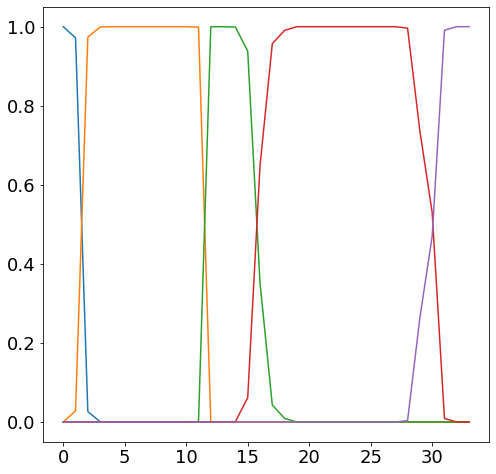

In [20]:
lls = np.vstack([logpdf_gauss(test_ne[3], m, c) for m, c in zip(mus_ne, covs_ne)]).T
ttl, gamma = forward_backward(lls, tr, ip, fs)
plt.plot(gamma);